# ディープラーニングで関数近似
## 1次元関数の近似
n次関数によるフィットでできるようなものだと面白くないので、
$$
y = \sin (ax)
$$
を近似することを考える。定義域は$[0,1]$、$a=20\pi$とした。まずは教師データを10000点準備する。今回は純粋にニューラルネットの表現力を知りたいため、オーバーフィッティングの問題を考えなくてよいよう、十分なデータ数を用意した。

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from torch.autograd import grad, Variable
from torch.utils import data
import torch.nn.functional as F
from tqdm import tnrange

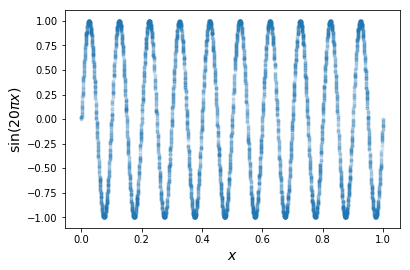

In [2]:
N = 10000
x_data = np.random.rand(N)
y_data = np.sin(np.pi*x_data * 20)
plt.scatter(x_data, y_data, alpha=0.1, marker=".")
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\sin (20\pi x)$", fontsize=14)
plt.show()

### n次関数による近似
比較のため、n次関数による近似を行う。次数は3~10とする。

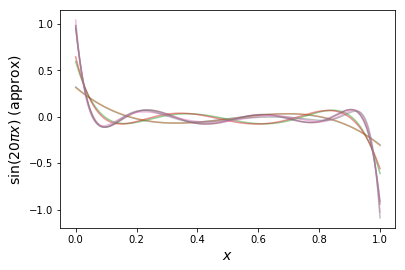

In [3]:
x = np.linspace(0, 1, 1000)
for i in range(3, 11):
    fit = np.polyfit(x_data, y_data, i)
    f = np.poly1d(fit)
    plt.plot(x, f(x), alpha=0.5)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\sin (20\pi x)$ (approx)", fontsize=14)
plt.show()

全くダメダメなことがわかる。n次関数のような大域的なものではなく、ガウス基底のような局所的な基底関数を選べばうまく行くかもしれないが、今回の主題とは外れるので議論しない。
### ディープラーニングによる近似
全結合型ニューラルネットで近似する。隠れ層のノード数は20で固定し、層数はいい感じになるように調整する。活性化関数はReLUを使用する。最適化にはRMSpropを使用し、学習率以外はデフォルトパラメータのままとする。

In [12]:
class Net(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_size=20, hidden_layer_size=2, activation=nn.Tanh):
        super().__init__()
        self.inp = nn.Sequential(
            nn.Linear(input_shape, hidden_size), 
            activation()
        )
        fc = [nn.Sequential(nn.Linear(hidden_size, hidden_size) ,
                            activation()
                           ) for _ in range(hidden_layer_size)]
        self.fc = nn.ModuleList(fc)
        self.out = nn.Sequential(
            nn.Linear(hidden_size, output_shape),
        )
        
    def forward(self, x):
        f = self.inp(x)
        for i in range(len(self.fc)):
            f = self.fc[i](f)
        return self.out(f)

class Solver:
    def __init__(self, input_shape=1, output_shape=1,
                 hidden_size=20, hidden_layer_size=2,
                 activation=nn.ReLU, lr=1e-3):
        self.net = Net(input_shape=input_shape,
                       output_shape=output_shape,
                       hidden_size=hidden_size,
                       hidden_layer_size=hidden_layer_size,
                       activation=activation).to("cuda")
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
    
    def MSE(self, x, y):
        return (self.net(x) -y).pow(2).sum() / len(x)

    def train(self, x, y, N=10000):
        x_nn = torch.FloatTensor(x).requires_grad_().unsqueeze(-1).to("cuda")
        y_nn = torch.FloatTensor(y).requires_grad_().unsqueeze(-1).to("cuda")
        
        loss = []
        for i in tnrange(N, desc="Training"):
            self.optimizer.zero_grad()
            mse = self.MSE(x_nn, y_nn)
            if i % (N / 200) == 0:
                loss.append(mse.item())
            mse.backward()
            self.optimizer.step()
        plt.plot((N / 200) * np.arange(len(loss)), loss)
        plt.xlabel("training steps", fontsize=14)
        plt.ylabel("MSE loss", fontsize=14)
        plt.show()
            
    def predict(self, x):
        x_nn = torch.FloatTensor(x).unsqueeze(-1).to("cuda")
        return self.net(x_nn).cpu().squeeze().tolist()

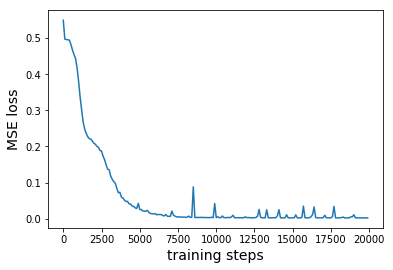

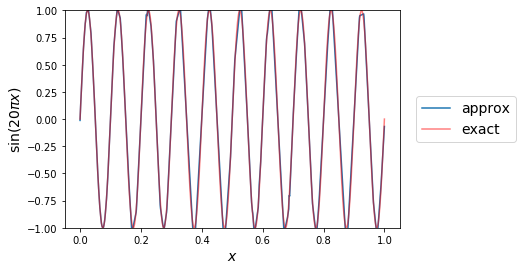

In [13]:
solver = Solver(hidden_layer_size=5, lr=1e-3)
solver.train(x_data, y_data, N=20000)

x = np.linspace(0, 1, 1000)

y = solver.predict(x)
plt.plot(x, y, label="approx")

plt.plot(x, np.sin(np.pi*x * 20), c="r", alpha=0.5, label="exact")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, fontsize=14)
plt.ylim([-1, 1])
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\sin (20\pi x)$", fontsize=14)
plt.show()

結構いい感じ。定義域外がどうなっているのか見てみる。

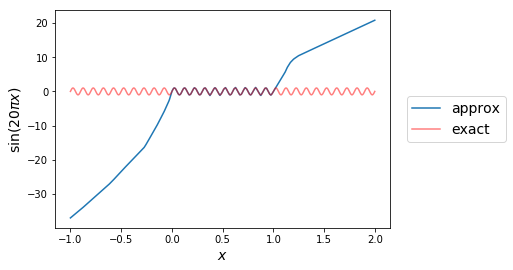

In [15]:
x = np.linspace(-1, 2, 1000)

y = solver.predict(x)
plt.plot(x, y, label="approx")

plt.plot(x, np.sin(np.pi*x * 20), c="r", alpha=0.5, label="exact")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, fontsize=14)
# plt.ylim([-1, 1])
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\sin (20\pi x)$", fontsize=14)
plt.show()

流石に局所的である。もちろん、[0,1]のみでサイン関数の挙動をして、それ以外の区間で違う挙動をする関数もあるので、当たり前といえば当たり前の結果。次にガウス関数を学習してみる。

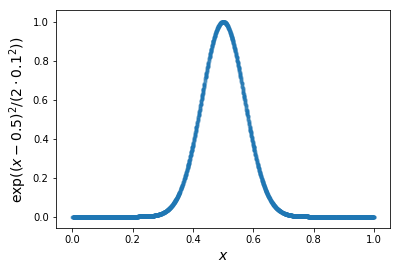

In [28]:
N = 10000
x_data = np.random.rand(N)
y_data = np.exp(-(x_data - 0.5) ** 2/(0.1**2))
plt.scatter(x_data, y_data, alpha=0.1, marker=".")
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\exp ((x-0.5)^2/(2 \cdot 0.1^2))$", fontsize=14)
plt.show()

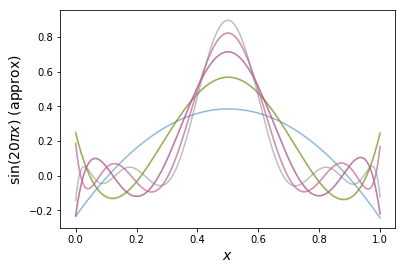

In [29]:
x = np.linspace(0, 1, 1000)
for i in range(3, 11):
    fit = np.polyfit(x_data, y_data, i)
    f = np.poly1d(fit)
    plt.plot(x, f(x), alpha=0.5)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\exp ((x-0.5)^2/(2 \cdot 0.1^2))$ (approx)", fontsize=14)
plt.show()

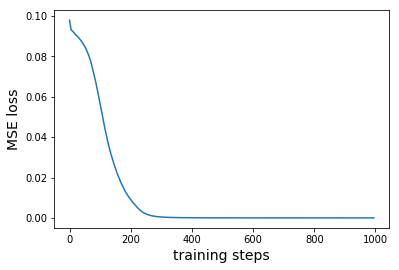

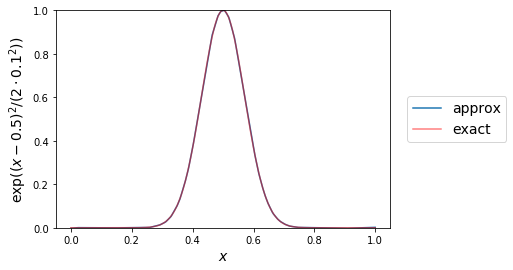

In [37]:
solver = Solver(hidden_layer_size=2, lr=1e-3)
solver.train(x_data, y_data, N=1000)

x = np.linspace(0, 1, 1000)

y = solver.predict(x)
plt.plot(x, y, label="approx")

plt.plot(x, np.exp(-(x - 0.5) ** 2/(0.1**2)), c="r", alpha=0.5, label="exact")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, fontsize=14)
plt.ylim([0, 1])
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$\exp ((x-0.5)^2/(2 \cdot 0.1^2))$", fontsize=14)
plt.show()

sin関数よりも簡単なので収束が速い。